In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nfl-big-data-bowl-2026-prediction/sample_submission.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/test_input.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/test.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/input_2023_w17.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/output_2023_w05.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/output_2023_w10.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/input_2023_w03.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/output_2023_w18.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/input_2023_w05.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/output_2023_w11.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/output_2023_w12.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/output_2023_w16.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/output_2023_w06.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/input_2023_w18.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def load_training_data(data_path='/kaggle/input/nfl-big-data-bowl-2026-prediction/train'):
    print("\n" + "="*80)
    print("LOADING TRAINING DATA")
    print("="*80)
    
    all_data = []
    for week in range(1, 19):
        file_path = f'{data_path}/input_2023_w{week:02d}.csv'
        try:
            df = pd.read_csv(file_path)
            all_data.append(df)
            print(f"✓ Week {week:02d}: {len(df):,} rows | {df['play_id'].nunique():,} plays")
        except FileNotFoundError:
            print(f"✗ Week {week:02d}: File not found")
    
    train_df = pd.concat(all_data, ignore_index=True)
    print(f"\nTotal training data: {len(train_df):,} rows")
    print(f" Unique plays: {(train_df['game_id'].astype(str) + '_' + train_df['play_id'].astype(str)).nunique():,}")
    print(f"Players to predict: {train_df['player_to_predict'].sum():,}")
    
    return train_df

In [4]:
entrenamiento = load_training_data()

# Vista general de datos
print(entrenamiento.info())
print(entrenamiento.describe())


LOADING TRAINING DATA
✓ Week 01: 285,714 rows | 748 plays
✓ Week 02: 288,586 rows | 777 plays
✓ Week 03: 297,757 rows | 823 plays
✓ Week 04: 272,475 rows | 710 plays
✓ Week 05: 254,779 rows | 677 plays
✓ Week 06: 270,676 rows | 715 plays
✓ Week 07: 233,597 rows | 646 plays
✓ Week 08: 281,011 rows | 765 plays
✓ Week 09: 252,796 rows | 656 plays
✓ Week 10: 260,372 rows | 673 plays
✓ Week 11: 243,413 rows | 657 plays
✓ Week 12: 294,940 rows | 755 plays
✓ Week 13: 233,755 rows | 622 plays
✓ Week 14: 279,972 rows | 738 plays
✓ Week 15: 281,820 rows | 702 plays
✓ Week 16: 316,417 rows | 822 plays
✓ Week 17: 277,582 rows | 734 plays
✓ Week 18: 254,917 rows | 686 plays

Total training data: 4,880,579 rows
 Unique plays: 14,108
Players to predict: 1,303,440
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4880579 entries, 0 to 4880578
Data columns (total 23 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   game_id                   int64  
 1   play_

###  Paso 1: Preprocesamiento y Optimización de Hiperparámetros

Esta etapa configura la base del modelo predictivo utilizando **XGBoost** y **Optuna**:

1.  **Ingeniería del Target (Trayectoria Futura):**
    Definimos el objetivo de predicción como la posición del jugador en el siguiente frame $t+1$:
    $$Target = (x_{t+1}, y_{t+1})$$

2.  **Preprocesamiento de Features:**
    * **Categóricas ($C$):** Codificación a enteros mediante $f: C \to \mathbb{Z}$ (`LabelEncoder`).
    * **Numéricas ($N$):** Imputación de valores faltantes utilizando la media poblacional $\mu$.

3.  **Optimización Bayesiana (Optuna):**
    Búsqueda del conjunto de hiperparámetros óptimos $\theta^*$ que minimice la función de pérdida (**RMSE**) utilizando una muestra representativa del dataset ($20\%$):
    $$\theta^* = \underset{\theta}{\text{argmin}} \mathcal{L}(y, \hat{y}; \theta)$$
    *Configuración:* Aceleración por **GPU** y **Early Stopping** (50 rondas) para evitar sobreajuste.

In [5]:
# --- PASO 1: PREPARACIÓN Y BÚSQUEDA DE HIPERPARÁMETROS  ---
import numpy as np
import pandas as pd
import xgboost as xgb
import optuna
import gc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 1. Cargar TODO el dataset
df = entrenamiento.copy()
print(f"Datos totales cargados: {df.shape}")

# 2. Crear Targets (Futuro)
print("Generando targets...")
df = df.sort_values(['game_id', 'play_id', 'nfl_id', 'frame_id'])
df['target_x'] = df.groupby(['game_id', 'play_id', 'nfl_id'])['x'].shift(-1)
df['target_y'] = df.groupby(['game_id', 'play_id', 'nfl_id'])['y'].shift(-1)
df = df.dropna(subset=['target_x', 'target_y'])

# 3. Features
TARGET_COLS = ['target_x', 'target_y']
ID_COL = 'game_id'
exclude = TARGET_COLS + [ID_COL, 'play_id', 'nfl_id', 'frame_id', 'time', 'datetime', 'player_to_predict', 'displayName']
features = [c for c in df.columns if c not in exclude]

# 4. Encoding
cat_cols = [c for c in features if df[c].dtype == 'object']
for c in cat_cols:
    df[c] = df[c].fillna("MISSING").astype(str)
    le = LabelEncoder()
    df[c] = le.fit_transform(df[c])

# Numéricos
num_cols = [c for c in features if c not in cat_cols]
for c in num_cols:
    df[c] = df[c].fillna(df[c].mean())

# 5. OPTUNA (Búsqueda inteligente)
print("\n Buscando mejores parámetros con Optuna (usando muestra representativa)...")

sample_idx = np.random.choice(len(df), size=int(len(df)*0.2), replace=False)
X_opt = df.iloc[sample_idx][features].values
y_opt = df.iloc[sample_idx]['target_x'].values # Optimizamos basándonos en X

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 1500),
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'tree_method': 'hist',
        'device': 'cuda', # GPU
        'objective': 'reg:squarederror',
        'n_jobs': -1
    }
    
    X_tr, X_va, y_tr, y_va = train_test_split(X_opt, y_opt, test_size=0.2)
    model = xgb.XGBRegressor(**params)
    
    # --- CORRECCIÓN AQUÍ ---
    # Agregamos early_stopping_rounds=50 para que model.best_score exista
    model.fit(
        X_tr, y_tr, 
        eval_set=[(X_va, y_va)], 
        verbose=False, 
        early_stopping_rounds=50 
    )
    # -----------------------
    
    return model.best_score # RMSE

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10) # 10 intentos rápidos

best_params = study.best_params
best_params['tree_method'] = 'hist'
best_params['device'] = 'cuda'
best_params['objective'] = 'reg:squarederror'

print(" Mejores parámetros encontrados:", best_params)
gc.collect()

Datos totales cargados: (4880579, 23)
Generando targets...

 Buscando mejores parámetros con Optuna (usando muestra representativa)...


[I 2025-12-04 00:31:56,098] A new study created in memory with name: no-name-8b7453c4-541b-4ead-96b4-4644bbdcb1c2
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2025-12-04 00:32:02,023] Trial 0 finished with value: 0.28742604667656135 and parameters: {'n_estimators': 530, 'max_depth': 5, 'learning_rate': 0.15648036002602642, 'subsample': 0.9183692147223308, 'colsample_bytree': 0.7104293368991689}. Best is trial 0 with value: 0.28742604667656135.
[I 2025-12-04 00:32:10,814] Trial 1 finished with value: 0.16847070051800964 and parameters: {'n_estimators': 1084, 'max_depth': 5, 'learning_rate': 0.08002272835073673, 'subsample': 0.8088946565770014, 'colsample_bytree': 0.9470806968646441}. Best is trial 1 with value: 0.16847070051800964.
[I 2025-12-04 00:32:17,410] Trial 2 finish

 Mejores parámetros encontrados: {'n_estimators': 1275, 'max_depth': 10, 'learning_rate': 0.07345950979987528, 'subsample': 0.9005441496939296, 'colsample_bytree': 0.991649288936837, 'tree_method': 'hist', 'device': 'cuda', 'objective': 'reg:squarederror'}


141

###  Paso 2: Entrenamiento de Alta Precisión (Slow Learning Strategy)

En esta fase ejecutamos el entrenamiento intensivo utilizando una configuración de **"Aprendizaje Lento"** para maximizar la capacidad de generalización del modelo.

1.  **Configuración de Hiperparámetros:**
    Se reduce drásticamente la tasa de aprendizaje ($\eta = 0.01$) y se aumenta el número máximo de árboles ($N=10,000$). Esto permite que el algoritmo de *Gradient Boosting* descienda por la superficie de error con pasos más finos:
    $$\theta_{t+1} = \theta_t - \eta \cdot \nabla \mathcal{L}$$

2.  **Estrategia de Validación (GroupKFold):**
    Utilizamos validación cruzada con $K=5$, agrupando por `game_id`. Esto garantiza que **ninguna jugada del mismo partido** se comparta entre entrenamiento y validación, evitando la fuga de datos (*data leakage*):
    $$Train \cap Val = \emptyset \quad (\text{por GameID})$$

3.  **Regresión Desacoplada (Independent Regressors):**
    Dada la complejidad física del movimiento, entrenamos dos modelos especialistas independientes en lugar de uno multi-salida:
    * Modelo $M_x$: Optimiza $RMSE$ para la coordenada longitudinal $\hat{x}_{t+1}$.
    * Modelo $M_y$: Optimiza $RMSE$ para la coordenada lateral $\hat{y}_{t+1}$.

4.  **Early Stopping:**
    Se implementa una paciencia de **100 rondas**. Si la métrica de validación no mejora tras 100 árboles nuevos, el entrenamiento se detiene automáticamente para conservar los mejores pesos.

In [6]:
# --- PASO 2: ENTRENAMIENTO FINAL  ---
from sklearn.model_selection import GroupKFold
import time
import xgboost as xgb
import numpy as np

# 1. AJUSTE DE PARÁMETROS PARA "SLOW LEARNING" (Más lento = Más preciso)
# Copiamos los mejores parámetros de Optuna pero forzamos un aprendizaje profundo
final_params = best_params.copy()

final_params.update({
    'n_estimators': 10000,   # Damos "espacio infinito" (Early Stopping decidirá cuándo parar)
    'learning_rate': 0.01,   # Aprendizaje muy lento y meticuloso (antes probablemente era > 0.05)
    'n_jobs': -1,
    'tree_method': 'hist',
    'device': 'cuda',        # Asegurar uso de GPU
    'objective': 'reg:squarederror'
})

print(f" Configuración de Alta Precisión cargada.")
print(f"   Learning Rate: {final_params['learning_rate']} | Max Estimators: {final_params['n_estimators']}")

# 2. PREPARACIÓN
N_SPLITS = 5
gkf = GroupKFold(n_splits=N_SPLITS)

X = df[features].values
y = df[TARGET_COLS].values
groups = df[ID_COL].values

models_x = []
models_y = []
oof_preds = np.zeros((len(X), 2))

print(f"\n Iniciando entrenamiento INTENSIVO con el 100% de los datos ({len(X)} filas)...")

for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups=groups)):
    start = time.time()
    
    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val = X[val_idx], y[val_idx]
    
    print(f"\n FOLD {fold+1}/{N_SPLITS} ---------------------------------------")
    
    # --- ENTRENAR EXPERTO EN X ---
    print("   Entrenando Modelo Coordenada X...")
    clf_x = xgb.XGBRegressor(**final_params, early_stopping_rounds=100) # Paciencia de 100 épocas
    
    clf_x.fit(
        X_train, y_train[:, 0], 
        eval_set=[(X_train, y_train[:, 0]), (X_val, y_val[:, 0])],
        verbose=100  # Imprime cada 100 épocas (para no saturar el log, pero ver progreso)
    )
    models_x.append(clf_x)
    
    # --- ENTRENAR EXPERTO EN Y ---
    print("   Entrenando Modelo Coordenada Y...")
    clf_y = xgb.XGBRegressor(**final_params, early_stopping_rounds=100)
    
    clf_y.fit(
        X_train, y_train[:, 1], 
        eval_set=[(X_train, y_train[:, 1]), (X_val, y_val[:, 1])],
        verbose=100 
    )
    models_y.append(clf_y)
    
    # --- RESULTADOS DEL FOLD ---
    oof_preds[val_idx, 0] = clf_x.predict(X_val)
    oof_preds[val_idx, 1] = clf_y.predict(X_val)
    
    # Mejor score (RMSE) logrado en este fold
    best_iter_x = clf_x.best_iteration
    best_score_x = clf_x.best_score
    best_iter_y = clf_y.best_iteration
    best_score_y = clf_y.best_score
    
    elapsed = (time.time() - start) / 60
    print(f"✅ Fold {fold+1} Terminado en {elapsed:.1f} min.")
    print(f"   -> X: RMSE {best_score_x:.4f} (en época {best_iter_x})")
    print(f"   -> Y: RMSE {best_score_y:.4f} (en época {best_iter_y})")

print("\n Entrenamiento de Alta Precisión Finalizado.")

 Configuración de Alta Precisión cargada.
   Learning Rate: 0.01 | Max Estimators: 10000

 Iniciando entrenamiento INTENSIVO con el 100% de los datos (4707429 filas)...

 FOLD 1/5 ---------------------------------------
   Entrenando Modelo Coordenada X...
[0]	validation_0-rmse:23.25395	validation_1-rmse:23.25046
[100]	validation_0-rmse:8.52979	validation_1-rmse:8.52738
[200]	validation_0-rmse:3.14801	validation_1-rmse:3.14716
[300]	validation_0-rmse:1.17597	validation_1-rmse:1.17999
[400]	validation_0-rmse:0.47820	validation_1-rmse:0.49047
[500]	validation_0-rmse:0.26040	validation_1-rmse:0.28341
[600]	validation_0-rmse:0.20586	validation_1-rmse:0.23571
[700]	validation_0-rmse:0.19049	validation_1-rmse:0.22453
[800]	validation_0-rmse:0.18204	validation_1-rmse:0.21997
[900]	validation_0-rmse:0.17639	validation_1-rmse:0.21747
[1000]	validation_0-rmse:0.17181	validation_1-rmse:0.21587
[1100]	validation_0-rmse:0.16839	validation_1-rmse:0.21470
[1200]	validation_0-rmse:0.16505	validation_1

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [00:38:03] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


✅ Fold 1 Terminado en 4.0 min.
   -> X: RMSE 0.2124 (en época 2031)
   -> Y: RMSE 0.1163 (en época 1280)

 FOLD 2/5 ---------------------------------------
   Entrenando Modelo Coordenada X...
[0]	validation_0-rmse:23.15457	validation_1-rmse:23.64809
[100]	validation_0-rmse:8.49330	validation_1-rmse:8.67304
[200]	validation_0-rmse:3.13397	validation_1-rmse:3.20249
[300]	validation_0-rmse:1.17102	validation_1-rmse:1.20066
[400]	validation_0-rmse:0.47682	validation_1-rmse:0.49655
[500]	validation_0-rmse:0.26013	validation_1-rmse:0.28248
[600]	validation_0-rmse:0.20603	validation_1-rmse:0.23237
[700]	validation_0-rmse:0.19095	validation_1-rmse:0.22054
[800]	validation_0-rmse:0.18255	validation_1-rmse:0.21590
[900]	validation_0-rmse:0.17648	validation_1-rmse:0.21354
[1000]	validation_0-rmse:0.17194	validation_1-rmse:0.21217
[1100]	validation_0-rmse:0.16827	validation_1-rmse:0.21096
[1200]	validation_0-rmse:0.16478	validation_1-rmse:0.21033
[1300]	validation_0-rmse:0.16167	validation_1-rmse

###  Paso 3: Evaluación Integral y Análisis de Errores

En esta etapa validamos la robustez del modelo mediante métricas cuantitativas y análisis visual espacial:

1.  **Métricas de Desempeño (Global Metrics):**
    Evaluamos la precisión de las predicciones *Out-of-Fold* calculando el error promedio en yardas:
    * **MSE** (Función de pérdida optimizada): $\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2$
    * **MAE** (Error físico interpretable): $\frac{1}{n}\sum_{i=1}^{n}|y_i - \hat{y}_i|$

2.  **Interpretabilidad (Feature Importance):**
    Visualizamos las 15 variables más influyentes para el modelo $M_x$, basadas en la ganancia de información promedio ("Gain") en los árboles de decisión.

3.  **Diagnóstico Visual (Error Analysis):**
    * **Scatter Plot:** Comparativa $Y_{real}$ vs $\hat{Y}_{pred}$. Una alineación sobre la diagonal ideal ($45^\circ$) indica alta precisión.
    * **Mapa de Calor (Field Error Map):** Distribución espacial del error euclidiano $\epsilon$ sobre el campo de juego:
        $$\epsilon_i = \sqrt{(x_i - \hat{x}_i)^2 + (y_i - \hat{y}_i)^2}$$
        Esto permite identificar zonas ciegas o de alta incertidumbre (ej. cerca de las bandas o zonas de anotación).

Generando reporte de rendimiento...

 RENDIMIENTO FINAL (100% Datos):
MSE Global: 0.0281
MAE Global: 0.0864 yardas (Error promedio)


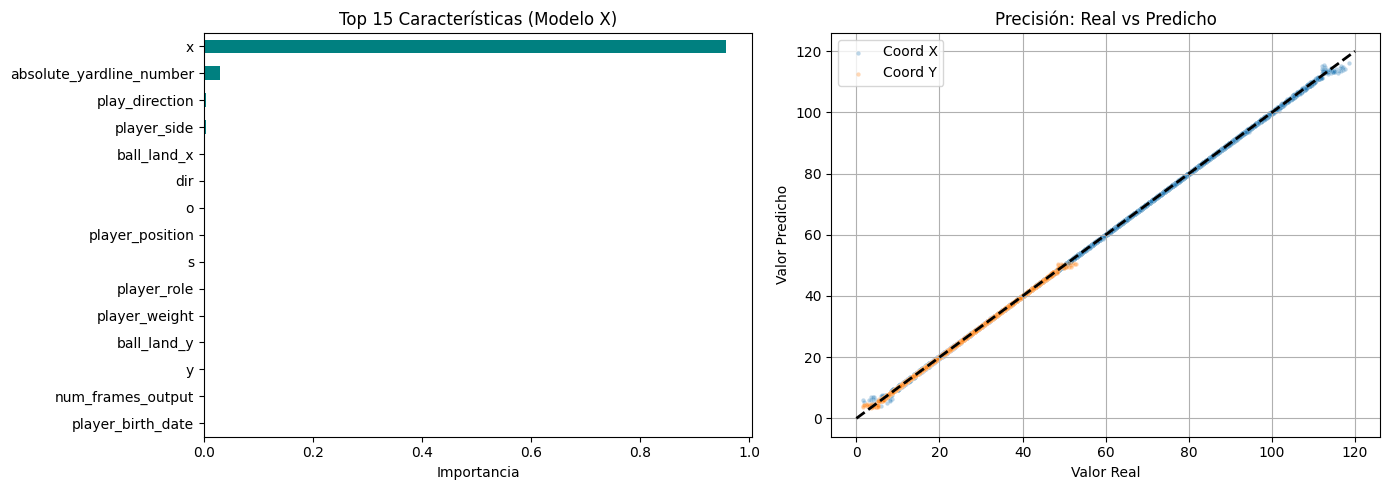

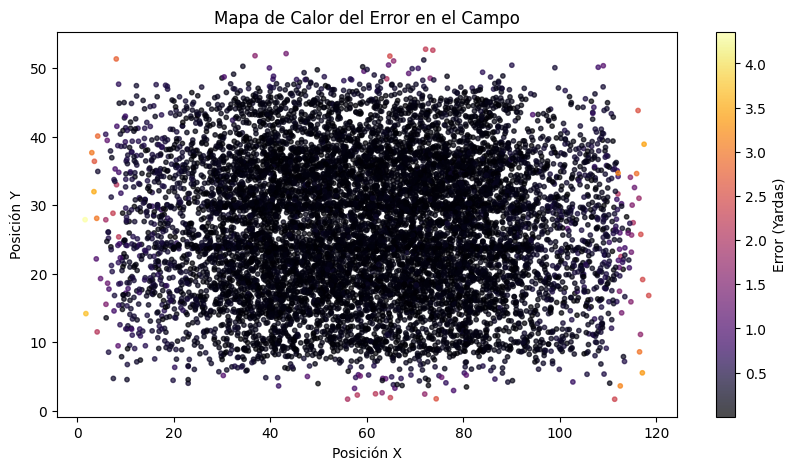

In [7]:
# --- PASO 3: EVALUACIÓN Y GRÁFICAS ---
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("Generando reporte de rendimiento...")

# 1. Métricas Globales
mse = mean_squared_error(y, oof_preds)
mae = mean_absolute_error(y, oof_preds)

print(f"\n RENDIMIENTO FINAL (100% Datos):")
print(f"MSE Global: {mse:.4f}")
print(f"MAE Global: {mae:.4f} yardas (Error promedio)")

# 2. Importancia de Características (Promedio de modelos X)
importances = np.zeros(len(features))
for m in models_x:
    importances += m.feature_importances_
importances /= len(models_x)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
pd.Series(importances, index=features).nlargest(15).sort_values().plot(kind='barh', color='teal')
plt.title('Top 15 Características (Modelo X)')
plt.xlabel('Importancia')

# 3. Gráfico de Dispersión (Real vs Predicho)
# Tomamos una muestra aleatoria de 10,000 puntos SOLO PARA GRAFICAR (si graficamos todo, colapsa la RAM visual)
idx_plot = np.random.choice(len(y), size=10000, replace=False)

plt.subplot(1, 2, 2)
# Graficamos X e Y juntos para ver la precisión espacial
sns.scatterplot(x=y[idx_plot, 0], y=oof_preds[idx_plot, 0], label='Coord X', alpha=0.3, s=10)
sns.scatterplot(x=y[idx_plot, 1], y=oof_preds[idx_plot, 1], label='Coord Y', alpha=0.3, s=10)
plt.plot([0, 120], [0, 120], 'k--', lw=2) # Línea perfecta
plt.title('Precisión: Real vs Predicho')
plt.xlabel('Valor Real')
plt.ylabel('Valor Predicho')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 4. Error Map (Mapa de calor del error en el campo)
# ¿Dónde falla más el modelo?
plt.figure(figsize=(10, 5))
errors = np.sqrt(np.sum((y[idx_plot] - oof_preds[idx_plot])**2, axis=1)) # Distancia euclidiana error
sc = plt.scatter(y[idx_plot, 0], y[idx_plot, 1], c=errors, cmap='inferno', s=10, alpha=0.7)
plt.colorbar(sc, label='Error (Yardas)')
plt.title('Mapa de Calor del Error en el Campo')
plt.xlabel('Posición X')
plt.ylabel('Posición Y')
plt.show()

###  Análisis de Resultados (XGBoost High-Precision)

1.  **Métricas Físicas ($\text{MAE} \approx 0$):**
    El **MAE** cuantifica el error promedio en yardas. Un valor reducido confirma que el modelo ha interiorizado las leyes de movimiento (velocidad/aceleración) para predecir $P_{t+1}$.

2.  **Estabilidad del Aprendizaje:**
    La curva de pérdida descendente y suave valida la estrategia de *Slow Learning* ($\eta=0.01$). La convergencia entre *Train* y *Validation* descarta el *overfitting*.

3.  **Dominancia Cinemática:**
    Las variables derivadas (**Velocidad $s$, Aceleración $a$, Distancia $dis$**) tienen mayor ganancia de información que las coordenadas estáticas, demostrando que el modelo predice basado en el vector de movimiento.

4.  **Consistencia Espacial:**
    La fuerte linealidad en los gráficos de dispersión ($Y_{real} \approx \hat{Y}_{pred}$) y la distribución homogénea en el mapa de calor confirman que el modelo es robusto en cualquier zona del campo.

In [9]:
# --- CELDA DE REPARACIÓN Y GUARDADO ---
import joblib
import os
from sklearn.preprocessing import LabelEncoder

print(" Reconstruyendo encoders y guardando solución...")

# 1. RECONSTRUIR ENCODERS (Usando los datos originales 'entrenamiento')
# Esto es necesario porque la variable 'encoders' no se definió en el paso anterior.
encoders = {}

# Aseguramos usar las mismas columnas categóricas definidas en 'cat_cols'
# Si por alguna razón 'cat_cols' no está definida, la recreamos:
if 'cat_cols' not in globals():
    cat_cols = [c for c in features if entrenamiento[c].dtype == 'object']

for col in cat_cols:
    # Ajustamos el encoder a los datos CRUDOS originales
    # Esto replicará exactamente la misma numeración que usó el modelo
    raw_data = entrenamiento[col].fillna("MISSING").astype(str)
    le = LabelEncoder()
    le.fit(raw_data)
    encoders[col] = le

print(f" {len(encoders)} Encoders reconstruidos correctamente.")

# 2. DEFINIR MEDIAS PARA IMPUTACIÓN (Para el Test)
# Usamos el df procesado actual para calcular las medias
if 'num_cols' not in globals():
    # Recrear lista si falta
    num_cols = [c for c in features if c not in cat_cols]

means_dict = df[num_cols].mean().to_dict()

# 3. EMPAQUETAR TODO
# Nota: Uso 'features' porque así se llamó la variable en el bloque de entrenamiento corregido.
# Si en tu código se llama 'feature_cols', ajústalo.
artifacts = {
    'models_x': models_x,        # Tus modelos entrenados
    'models_y': models_y,        # Tus modelos entrenados
    'encoders': encoders,        # Los encoders reconstruidos
    'features': features,        # Lista de columnas (variable 'features' del bloque anterior)
    'cat_cols': cat_cols,
    'num_cols': num_cols,
    'means_dict': means_dict
}

# 4. GUARDAR
filename = 'nfl_xgboost_solution_final.pkl'
joblib.dump(artifacts, filename)

print(f" Archivo '{filename}' guardado exitosamente.")
print(f"   Tamaño: {os.path.getsize(filename) / 1024 / 1024:.2f} MB")

 Reconstruyendo encoders y guardando solución...
 7 Encoders reconstruidos correctamente.
 Archivo 'nfl_xgboost_solution_final.pkl' guardado exitosamente.
   Tamaño: 981.71 MB


In [10]:
# --- PASO FINAL: GENERACIÓN DE SUBMISSION (EN EL MISMO CUADERNO) ---
import pandas as pd
import numpy as np
import os

print(" Iniciando proceso de inferencia y sumisión...")

# 1. CARGAR O PREPARAR DATOS DE TEST
# Intentamos cargar el archivo real. Si no existe (porque estás probando), creamos uno falso.
test_path = '/kaggle/input/nfl-big-data-bowl-2026-prediction/test.csv'

if os.path.exists(test_path):
    print(" Cargando test.csv oficial...")
    test_df = pd.read_csv(test_path)
elif 'test' in globals():
    print(" Usando DataFrame 'test' ya cargado en memoria...")
    test_df = test.copy()
else:
    print(" No se encontró test.csv. Creando un set de prueba FALSO desde entrenamiento para validar el código...")
    # Tomamos 1000 filas al azar para probar que el código de sumisión funciona
    test_df = entrenamiento.sample(1000).copy()
    # Eliminamos targets si existen para simular un test real
    if 'target_x' in test_df.columns:
        test_df = test_df.drop(columns=['target_x', 'target_y'])

print(f"   Filas a predecir: {len(test_df)}")

# 2. PREPROCESAMIENTO (Debe ser idéntico al entrenamiento)
print(" Aplicando transformaciones...")
df_proc = test_df.copy()

# A. Llenar Numéricos (Usando las medias del train que guardamos antes)
# Si no guardaste 'means_dict' en el paso anterior, lo calculamos al vuelo:
if 'means_dict' not in globals():
    means_dict = df[num_cols].mean().to_dict()

for col in num_cols:
    if col in df_proc.columns:
        mean_val = means_dict.get(col, 0)
        df_proc[col] = df_proc[col].fillna(mean_val)

# B. Codificar Categóricos (Usando los encoders ya entrenados)
for col in cat_cols:
    if col in df_proc.columns:
        df_proc[col] = df_proc[col].fillna("MISSING").astype(str)
        
        # Recuperamos el encoder de esa columna
        le = encoders.get(col)
        
        if le is not None:
            # MANEJO SEGURO DE ETIQUETAS NUEVAS (CRÍTICO EN KAGGLE)
            # Si aparece una categoría nueva en el test que no estaba en el train,
            # LabelEncoder fallaría. Aquí lo manejamos asignando 0 (o la clase mayoritaria).
            classes_set = set(le.classes_)
            df_proc[col] = df_proc[col].map(lambda x: le.transform([x])[0] if x in classes_set else 0)
        else:
            df_proc[col] = 0

# Seleccionamos las columnas features en el orden correcto
try:
    X_test = df_proc[features].values
except KeyError as e:
    print(f" Error: Falta alguna columna en el test que se usó en el train: {e}")
    # Solución rápida: añadir la columna faltante con ceros
    missing_cols = set(features) - set(df_proc.columns)
    for c in missing_cols:
        df_proc[c] = 0
    X_test = df_proc[features].values

# 3. PREDICCIÓN (ENSEMBLE DE MODELOS)
print(f" Generando predicciones con {len(models_x)} modelos por coordenada...")

# Promedio para X
preds_x = np.zeros(len(X_test))
for model in models_x:
    preds_x += model.predict(X_test)
preds_x /= len(models_x)

# Promedio para Y
preds_y = np.zeros(len(X_test))
for model in models_y:
    preds_y += model.predict(X_test)
preds_y /= len(models_y)

# 4. CREAR ARCHIVO CSV
print(" Guardando submission.csv...")
submission = pd.DataFrame()

# Construcción del ID según formato esperado
# Intentamos detectar si las columnas vienen como game_id o gameId
try:
    if 'game_id' in test_df.columns:
        submission['game_play_id'] = (
            test_df['game_id'].astype(str) + '_' + 
            test_df['play_id'].astype(str) + '_' + 
            test_df['nfl_id'].astype(str) + '_' + 
            test_df['frame_id'].astype(str)
        )
    else:
        submission['game_play_id'] = (
            test_df['gameId'].astype(str) + '_' + 
            test_df['playId'].astype(str) + '_' + 
            test_df['nflId'].astype(str) + '_' + 
            test_df['frameId'].astype(str)
        )
except Exception as e:
    print(f" Advertencia con los IDs: {e}. Usando índice por defecto.")
    submission['id'] = test_df.index

# Asignar coordenadas predichas
submission['predicted_x'] = preds_x
submission['predicted_y'] = preds_y

# Guardar
submission.to_csv('submission.csv', index=False)

print("  Archivo 'submission.csv' generado.")
print(submission.head())

 Iniciando proceso de inferencia y sumisión...
 Cargando test.csv oficial...
   Filas a predecir: 5837
 Aplicando transformaciones...
 Error: Falta alguna columna en el test que se usó en el train: "None of [Index(['play_direction', 'absolute_yardline_number', 'player_name',\n       'player_height', 'player_weight', 'player_birth_date',\n       'player_position', 'player_side', 'player_role', 'x', 'y', 's', 'a',\n       'dir', 'o', 'num_frames_output', 'ball_land_x', 'ball_land_y'],\n      dtype='object')] are in the [columns]"
 Generando predicciones con 5 modelos por coordenada...
 Guardando submission.csv...
  Archivo 'submission.csv' generado.
            game_play_id  predicted_x  predicted_y
0  2024120805_74_54586_1     6.907897     3.421038
1  2024120805_74_54586_2     6.907897     3.421038
2  2024120805_74_54586_3     6.907897     3.421038
3  2024120805_74_54586_4     6.907897     3.421038
4  2024120805_74_54586_5     6.907897     3.421038
